In [1]:
# Подключаем датасет.
from keras.datasets import cifar10, cifar100
from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils, to_categorical
import numpy
from keras import backend as K

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

#Загружаем данные x_train и x_test содержат двухмерный массив с изображение цифр
# x_test, y_test массив с проверочными данными сети.  
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [2]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

In [3]:
def recall_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_(y_true, y_pred):
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', f1_, precision_, recall_])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

In [5]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=64)
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

print(hist.history)

Epoch 1/25
782/782 [==============================] - 358s 455ms/step - loss: 2.1125 - accuracy: 0.2049 - f1_: 0.0256 - precision_: 0.2109 - recall_: 0.0144 - val_loss: 1.6511 - val_accuracy: 0.3897 - val_f1_: 0.1678 - val_precision_: 0.6491 - val_recall_: 0.0973
Epoch 2/25
782/782 [==============================] - 278s 355ms/step - loss: 1.5828 - accuracy: 0.4211 - f1_: 0.2660 - precision_: 0.6357 - recall_: 0.1718 - val_loss: 1.3633 - val_accuracy: 0.5005 - val_f1_: 0.4084 - val_precision_: 0.6762 - val_recall_: 0.2945
Epoch 3/25
782/782 [==============================] - 300s 384ms/step - loss: 1.3642 - accuracy: 0.5030 - f1_: 0.4137 - precision_: 0.6871 - recall_: 0.2987 - val_loss: 1.2279 - val_accuracy: 0.5539 - val_f1_: 0.4799 - val_precision_: 0.7330 - val_recall_: 0.3589
Epoch 4/25
782/782 [==============================] - 300s 383ms/step - loss: 1.2156 - accuracy: 0.5644 - f1_: 0.5042 - precision_: 0.7320 - recall_: 0.3871 - val_loss: 1.0834 - val_accuracy: 0.6159 - val_f1_

Results:
Accuracy 0.7922000288963318
F1 0.793916642665863
Precision 0.8403058052062988
Recall 0.7536941170692444


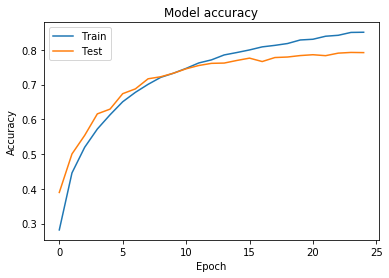

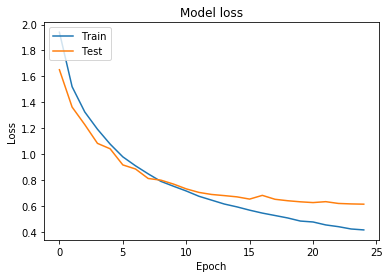

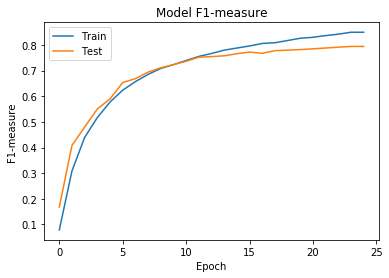

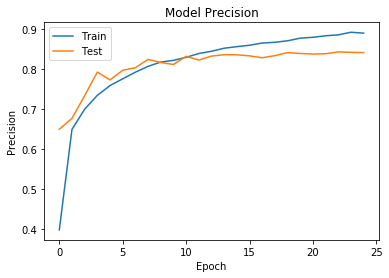

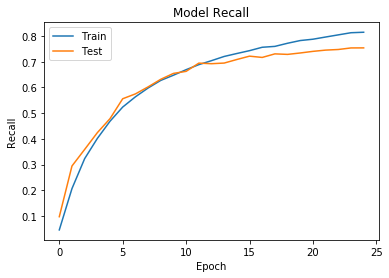

In [7]:
import matplotlib.pyplot as plt

print ("Results:")
print ("Accuracy", accuracy)
print ("F1", f1_score)
print ("Precision", precision)
print ("Recall", recall)

# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['f1_'])
plt.plot(hist.history['val_f1_'])
plt.title('Model F1-measure')
plt.ylabel('F1-measure')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['precision_'])
plt.plot(hist.history['val_precision_'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['recall_'])
plt.plot(hist.history['val_recall_'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
model.save('model_cifar-10.h5')  # Сохранение обученной модели
del model  # Удаление модели.

In [101]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train_, y_train_), (x_test_, y_test_) = cifar100.load_data()

In [102]:
arr_x = []
arr_y = []
for i in range(y_train_.size-1):
    if(y_train_[i]>=60 | y_train_[i]<=64):
        arr_x.append(x_train_[i])        
        arr_y.append(y_train_[i])
        
print("Train only cifar-10:", x_train.size, y_train.size)

arr_x = numpy.array(arr_x)
arr_y = numpy.array(arr_y)
x_train = numpy.vstack([x_train, arr_x])
y_train = numpy.vstack([y_train, arr_y])

print("Train and cifar-100:", x_train.size, y_train.size)
# print("Train cifar-100:", arr_x.size, arr_y.size)

Train only cifar-10: 153600000 50000
Train and cifar-100: 159744000 52000


In [103]:
arr_x = []
arr_y = []
for i in range(y_test_.size-1):
    if(y_test_[i]>=60 | y_test_[i]<=64):
        arr_x.append(x_test_[i])        
        arr_y.append(y_test_[i])
        
print("Test only cifar-10:", x_test.size, y_test.size)

arr_x = numpy.array(arr_x)
arr_y = numpy.array(arr_y)
x_test = numpy.vstack([x_test, arr_x])
y_test = numpy.vstack([y_test, arr_y])

print("Test and cifar-100:", x_test.size, y_test.size)

Test only cifar-10: 30720000 10000
Test and cifar-100: 31948800 10400


In [104]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

In [105]:
model = load_model('model_cifar-10.h5', custom_objects={'accuracy': accuracy, 'f1_': f1_,'precision_': precision_,'recall_': recall_})
model.pop() #remove the last layer - 'Dense' layer with 10 units

for layer in model.layers:
    layer.trainable = False
model.add(Dense(units = num_classes, activation = 'softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', f1_, precision_, recall_])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

In [106]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=64)
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

print(hist.history)

Epoch 1/25
813/813 [==============================] - 107s 131ms/step - loss: 0.9310 - accuracy: 0.7493 - f1_: 0.7121 - precision_: 0.8492 - recall_: 0.6342 - val_loss: 0.7156 - val_accuracy: 0.7700 - val_f1_: 0.7640 - val_precision_: 0.8316 - val_recall_: 0.7081
Epoch 2/25
813/813 [==============================] - 110s 136ms/step - loss: 0.5069 - accuracy: 0.8334 - f1_: 0.8292 - precision_: 0.8868 - recall_: 0.7794 - val_loss: 0.7092 - val_accuracy: 0.7731 - val_f1_: 0.7701 - val_precision_: 0.8326 - val_recall_: 0.7179
Epoch 3/25
813/813 [==============================] - 100s 123ms/step - loss: 0.5030 - accuracy: 0.8341 - f1_: 0.8331 - precision_: 0.8872 - recall_: 0.7860 - val_loss: 0.7008 - val_accuracy: 0.7754 - val_f1_: 0.7741 - val_precision_: 0.8322 - val_recall_: 0.7250
Epoch 4/25
813/813 [==============================] - 98s 120ms/step - loss: 0.4797 - accuracy: 0.8401 - f1_: 0.8407 - precision_: 0.8902 - recall_: 0.7972 - val_loss: 0.6986 - val_accuracy: 0.7767 - val_f1_:

Results:
Accuracy 0.7804807424545288
F1 0.7783898711204529
Precision 0.8326009511947632
Recall 0.7325961589813232


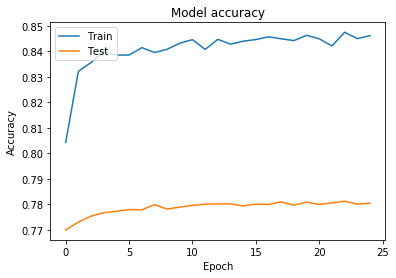

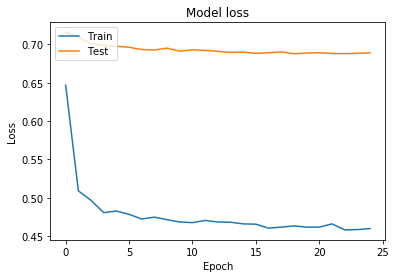

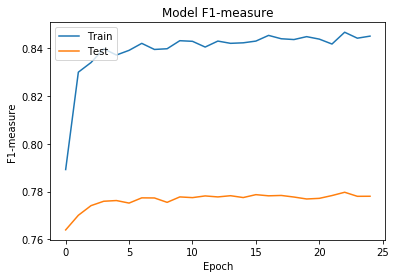

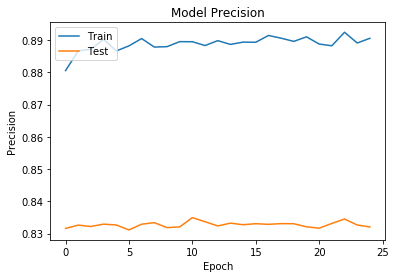

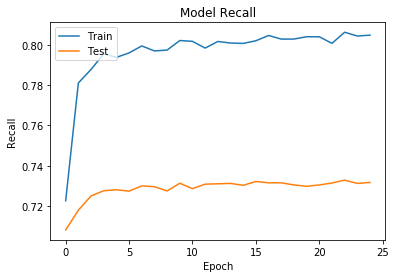

In [107]:
import matplotlib.pyplot as plt

print ("Results:")
print ("Accuracy", accuracy)
print ("F1", f1_score)
print ("Precision", precision)
print ("Recall", recall)

# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['f1_'])
plt.plot(hist.history['val_f1_'])
plt.title('Model F1-measure')
plt.ylabel('F1-measure')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['precision_'])
plt.plot(hist.history['val_precision_'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#
plt.plot(hist.history['recall_'])
plt.plot(hist.history['val_recall_'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [108]:
model.save('model_cifar-10&cifar-100.h5')  # Сохранение обученной модели
del model  # Удаление модели.